In [1]:
import os
import numpy as np
from gensim.models import Word2Vec
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

# ディレクトリの設定
save_dir = "../embeddings"
seasons = range(1, 23)

# 基準となるシーズンを設定（例: シーズン1）
base_season = 1

# シーズンごとの埋め込みモデルを読み込む
def load_embedding(season):
    embedding_file = os.path.join(save_dir, f"s{season}_single_ranked_teams_embedding")
    model = Word2Vec.load(embedding_file)
    return model.wv

# 基準シーズンの埋め込みを取得
base_embedding = load_embedding(base_season)

# 他のシーズンの埋め込みを基準に合わせて整合させる関数
def align_embeddings(base_embedding, target_embedding):
    # 共通の単語（ポケモン名）を取得
    common_vocab = list(set(base_embedding.index_to_key) & set(target_embedding.index_to_key))

    # 共通語彙のベクトルを取得
    base_vectors = np.array([base_embedding[word] for word in common_vocab])
    target_vectors = np.array([target_embedding[word] for word in common_vocab])

    # プロクルステス変換で整合
    R, _ = orthogonal_procrustes(target_vectors, base_vectors)
    aligned_vectors = np.dot(target_embedding.vectors, R)

    # aligned_vectors を KeyedVectors に戻す
    aligned_kv = KeyedVectors(vector_size=base_embedding.vector_size)
    aligned_kv.add_vectors(target_embedding.index_to_key, aligned_vectors)

    return aligned_kv

# シーズンごとの整合済み埋め込みを保存
aligned_embeddings = {base_season: base_embedding}

for season in seasons:
    if season != base_season:
        target_embedding = load_embedding(season)
        aligned_embedding = align_embeddings(base_embedding, target_embedding)
        aligned_embeddings[season] = aligned_embedding


カイリュー shift from 1 to 2: 0.03759322315454483
カイリュー shift from 2 to 3: 0.04086079075932503
カイリュー shift from 3 to 4: 0.036899883300065994
カイリュー shift from 4 to 5: 0.036059487611055374
カイリュー shift from 5 to 6: 0.03217253461480141
カイリュー shift from 6 to 7: 0.032710157334804535
カイリュー shift from 7 to 8: 0.03827107325196266
カイリュー shift from 8 to 9: 0.03437257558107376
カイリュー shift from 9 to 10: 0.03339604660868645
カイリュー shift from 10 to 11: 0.038245394825935364
カイリュー shift from 11 to 12: 0.03334002196788788
カイリュー shift from 12 to 13: 0.02859671786427498
カイリュー shift from 13 to 14: 0.032478660345077515
カイリュー shift from 14 to 15: 0.038773324340581894
カイリュー shift from 15 to 16: 0.02963617444038391
カイリュー shift from 16 to 17: 0.03258255869150162
カイリュー shift from 17 to 18: 0.03867226839065552
カイリュー shift from 18 to 19: 0.028718773275613785
カイリュー shift from 19 to 20: 0.03198520839214325
カイリュー shift from 20 to 21: 0.031654100865125656
カイリュー shift from 21 to 22: 0.03845134750008583


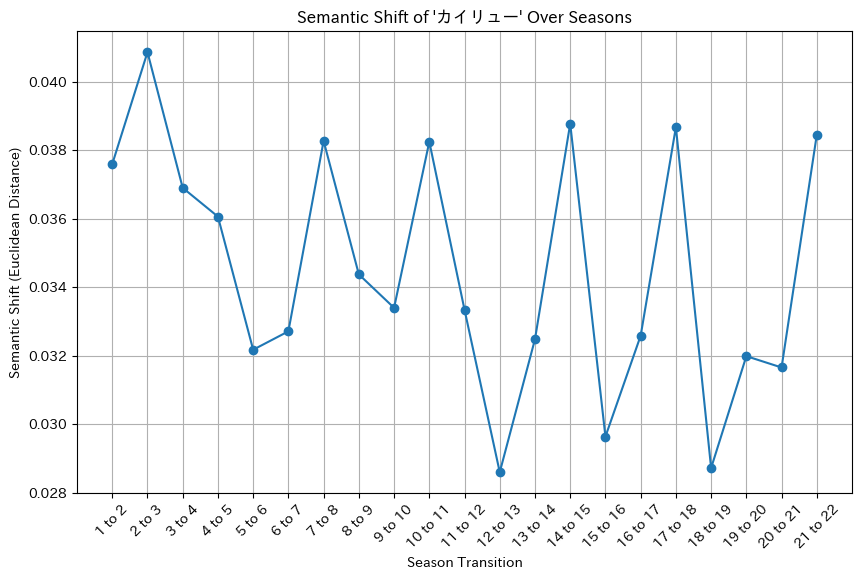

In [2]:
from numpy.linalg import norm
import japanize_matplotlib

# 特定の単語（ポケモン）の意味変化を計算する関数
def calculate_semantic_shift(word, aligned_embeddings, seasons):
    shifts = {}
    for i in range(len(seasons) - 1):
        season1 = seasons[i]
        season2 = seasons[i + 1]
        
        if word in aligned_embeddings[season1] and word in aligned_embeddings[season2]:
            embedding1 = aligned_embeddings[season1][word]
            embedding2 = aligned_embeddings[season2][word]
            
            # ベクトルのユークリッド距離を計算
            shift = norm(embedding2 - embedding1)
            shifts[f"{season1} to {season2}"] = shift
            
    return shifts

# 例: "カイリュー" の意味変化を計算
word = "カイリュー"
shifts = calculate_semantic_shift(word, aligned_embeddings, list(seasons))

# 結果を表示
for period, shift in shifts.items():
    print(f"{word} shift from {period}: {shift}")

# 時系列の変化をプロット
def plot_semantic_shift(word, shifts):
    periods = list(shifts.keys())
    values = list(shifts.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(periods, values, marker='o')
    plt.title(f"Semantic Shift of '{word}' Over Seasons")
    plt.xlabel("Season Transition")
    plt.ylabel("Semantic Shift (Euclidean Distance)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# "カイリュー" の変化を可視化
plot_semantic_shift(word, shifts)


In [3]:
from collections import defaultdict
from tqdm.auto import tqdm

# 全ポケモンの意味変化量を計算する関数
def calculate_all_semantic_shifts(aligned_embeddings, seasons):
    total_shifts = defaultdict(float)
    
    # 埋め込みに含まれる全ての単語を取得
    all_words = set()
    for embedding in tqdm(aligned_embeddings.values()):
        all_words.update(list(embedding.key_to_index.keys()))
    
    # 各ポケモンに対して意味変化を計算
    for word in all_words:
        for i in range(len(seasons) - 1):
            season1 = seasons[i]
            season2 = seasons[i + 1]
            
            if word in aligned_embeddings[season1] and word in aligned_embeddings[season2]:
                embedding1 = aligned_embeddings[season1][word]
                embedding2 = aligned_embeddings[season2][word]
                
                # ベクトルのユークリッド距離を計算し、累積
                shift = norm(embedding2 - embedding1)
                total_shifts[word] += shift
    
    return total_shifts

# 全ポケモンの意味変化量を計算
total_shifts = calculate_all_semantic_shifts(aligned_embeddings, list(seasons))

# 意味変化量が大きい順にソートして表示
sorted_shifts = sorted(total_shifts.items(), key=lambda x: x[1], reverse=True)

# 結果を表示
print("Most significant semantic shifts in Pokémon:")
for word, shift in sorted_shifts[:10]:  # 上位10件を表示
    print(f"{word}: Total Shift = {shift}")


  0%|          | 0/22 [00:00<?, ?it/s]

Most significant semantic shifts in Pokémon:
ゴチルゼル: Total Shift = 1.677339918911457
ハバタクカミ: Total Shift = 1.5684579461812973
テツノカイナ: Total Shift = 1.5237739607691765
トドロクツキ: Total Shift = 1.5197433605790138
テツノツツミ: Total Shift = 1.5105908140540123
パオジアン: Total Shift = 1.4236556962132454
ディンルー: Total Shift = 1.3853919804096222
イダイナキバ: Total Shift = 1.3418997079133987
イーユイ: Total Shift = 1.3406288921833038
チオンジェン: Total Shift = 1.3153268843889236


## 可視化の準備

In [4]:
from sklearn.manifold import TSNE

def rename_with_season(embedding, season):
    new_keyed_vectors = KeyedVectors(vector_size=embedding.vector_size)
    new_vocab = [f"{word}({season})" for word in embedding.index_to_key]
    new_keyed_vectors.add_vectors(new_vocab, embedding.vectors)
    return new_keyed_vectors

# すべてのシーズンの埋め込みを連結
all_words = []
all_vectors = []

for season, embedding in aligned_embeddings.items():
    renamed_embedding = rename_with_season(embedding, season)
    all_words.extend(renamed_embedding.index_to_key)
    all_vectors.extend(renamed_embedding.vectors)

# t-SNE で次元削減
tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(np.array(all_vectors))

In [6]:
import plotly.express as px
import pandas as pd

# DataFrameに変換
df = pd.DataFrame({
    'word': all_words,
    'x': reduced_vectors[:, 0],
    'y': reduced_vectors[:, 1]
})

# シーズンごとにフィルタリング用の情報を追加
df['season'] = [word.split('(')[-1].replace(')', '') for word in df['word']]

# スライダー付きのインタラクティブなプロットを作成
fig = px.scatter(df, x='x', y='y', text='word', hover_name='word', animation_frame='season')
fig.show()

In [8]:
df.to_csv("../output/aligned_pokemon_embeddings_tsne.csv", index=False)